In [182]:
import numpy as np
from numba import jit, vectorize, float64, prange
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys
from os.path import exists
from scipy import stats

mpl.rcParams["figure.dpi"] = 180
mpl.rcParams["legend.fontsize"] = 11
mpl.rcParams["font.size"] = 11
plt.rc("text", usetex=False)
plt.rc("text.latex", preamble=r"""
\usepackage{palatino}
\usepackage{newpxmath}""")
plt.rc("font", family="serif")

In [3]:
@jit(nopython = True)
def default_escape_cond(z):
    return np.abs(z) >= 2

@jit(nopython = True)
def main_cardioid(arg):
    point = 0.5 * np.exp(1j*arg) - 0.25 * np.exp(2*1j*arg)
    return np.abs(point)

#@jit(nopython = True)
#def cardioid_escape_cond(z):
    #if np.abs(z) <= main_cardioid(z.)

def mandelbrot_batch_factory(escape_condition):
    @jit(nopython = True, parallel = True, nogil = True)
    def _mandelbrot_mc(max_iter, samples):
        iter_counts = np.zeros(len(samples), dtype = np.int32)
        for i in prange(len(samples)):
            c = samples[i]
            zn = c
            for count in range(max_iter):
                zn = zn * zn + c
                if (escape_condition(zn)):
                    iter_counts[i] = count
                    break
                elif count == max_iter - 1:
                    iter_counts[i] = count
        return iter_counts
    return _mandelbrot_mc

mandelbrot_mc_default = mandelbrot_batch_factory(default_escape_cond)

def create_batch_uniform(N, re_low, re_high, im_low, im_high):
    samples_re = np.random.uniform(low = re_low, high = re_high, size = N)
    samples_im = np.random.uniform(low = im_low, high = im_high, size = N)
    samples = samples_re + 1j*samples_im
    return samples

In [4]:
@jit(nopython = True)
def set_count_from_iter_counts(max_iter, iter_counts):
    set_count = 0
    for count in iter_counts:
        if count == max_iter - 1:
            set_count += 1
    return set_count

@jit(nopython = True)
def area_from_iter_counts(re_low, re_high, im_low, im_high, iter_counts, max_iter):
    n = len(iter_counts)
    set_count = set_count_from_iter_counts(max_iter, iter_counts)
    domain_area = (re_high - re_low) * (im_high - im_low)
    return domain_area * set_count / n

In [5]:
@jit(nopython = True, parallel = True, nogil = True)
def mandelbrot_mc(max_iter, samples):
    """
    Counts the number of complex numbers in `samples` that do
    not meet the escape condition in `max_iter` recursions of
    the Mandelbrot polynomial, z(n+1) = z(n)^2 + c
    
    The escape condition used is |z(n)| >= 2
    
    Parameters
    ----------
    max_iter: positive integer
        Value of n up to which z(n) is evaluated
    
    samples: array of complex numbers
        values of z(0)
        
    Returns
    -------
    set_count: positive integer
        Number of complex numbers in `samples` that remain
        that do not satisfy the escape condition
    """
    set_count = 0
    for i in prange(len(samples)):
        c = samples[i]
        zn = c
        for j in range(1, max_iter):
            zn = zn*zn + c
            if (np.abs(zn) > 2):
                # numba should recognize this as a critical section
                break
            elif j == max_iter - 1:
                set_count += 1
    return set_count

@jit(nopython = True, nogil = True, parallel = True)
def mandelbrot_mc_area(re_low, re_high, im_low, im_high, max_iter, samples):
    """
    Calculates estimator of the area of the Mandelbrot set
    
    Parameters
    ----------
    re_low, re_high, im_low, im_high: float or float-like
        corners of bounding rectangle in the complex plane
    
    max_iter: positive integer
        value of n up to which z(n) is evaluated
    
    samples: array of complex numbers
        list of c values, assumed to be drawn from a uniform distribution
        in the bounding region
        
    Returns
    -------
    area: default numpy float (float32 or float64)
        estimate of the area of the mandelbrot set
    """
    count = mandelbrot_mc(max_iter, samples)
    return mandelbrot_area(count, len(samples), re_low, re_high, im_low, im_high)

@jit(nopython = True)
def mandelbrot_area(count, N, re_low, re_high, im_low, im_high):
    """
    TODO: Add docstring
    """
    rect_area = (re_high - re_low) * (im_high - im_low)
    return rect_area * count / N

@jit(nopython = True)
def mandelbrot_mc_runs(max_iter, samples, runs_count):
    counts = np.zeros(runs_count)
    for _ in range(runs_count):
        counts[i] = mandelbrot_mc(max_iter, samples)
    return counts

@jit(nopython = True)
def sample_mean_variance(counts):
    """Returns sample mean and sample variance of input array
    Parameters
    ----------
    counts: array of numbers
    
    Returns: 2-tuple (sample mean, sample variance)
    """
    n = len(counts)
    assert n > 1
    sample_mean = np.mean(counts)
    sample_variance = np.sum(np.power(counts - sample_mean, 2))/(n - 1)
    return (sample_mean, sample_variance)

In [6]:
N = 10**6
i = 1000
re_low, re_high = -2., 1.
im_low, im_high = -1.5, 1.5
area = (re_high - re_low) * (im_high - im_low)
samples = create_batch_uniform(N, re_low, re_high, im_low, im_high)

In [7]:
start_time = timer()
count = mandelbrot_mc_default(i, samples)
end_time = timer()
print(f"Execution time: {np.round(end_time - start_time, 2)} seconds")

Execution time: 1.25 seconds


In [8]:
# [WARN]: On Linux Mint 20, 16GB RAM, 2GB swap space, the kernel crashes as it runs out of memory for N = 1.0e9
N = 10**8
# TODO: save large random arrays
np.random.seed(10010)
samples = create_batch_uniform(N, re_low, re_high, im_low, im_high)

In [9]:
start_time = timer()
count = mandelbrot_mc_default(i,samples)
end_time = timer()
print(end_time - start_time)

12.4159062860017


For a fixed $i$, $\lim_{s\to\infty}A_{i,s} = A_i > A_\text{M}$, i.e. we are essentially calculating the area of a superset of the Mandelbrot set, one that includes points that would have met the escape condition after $i$ iterations.

Given a strictly increasing sequence of $i$-values $\{i_1, i_2, \ldots i_n\}$, we would like to pick $i = i_k$ for the smallest $k$ such that $|A_{k+1} - A_{k}|$ is less than some threshold value.

Henceforth, we simulate only the top half of the mandelbrot set.

In [10]:
i_values = np.array([50, 100, 200, 500, 1000, 2000], dtype = np.int64) #TODO: tweak values
s_values = np.array([10**i for i in range(4,9)], dtype = np.int64)
if not exists("monte_carlo_random_sampling.npz"):
    re_low, re_high = -2., 1.
    im_low, im_high = 0, 1.5

    number_of_batches = 50
    mean_areas = np.zeros((len(i_values), len(s_values)))
    sample_variances = np.zeros((len(i_values), len(s_values)))

    start_time = timer()
    for k,i in enumerate(i_values):
        # repeat `number_of_batches` times for each s-value
        for l,s in enumerate(s_values):
            areas_batch = np.zeros(number_of_batches)
            for j in range(number_of_batches):
                samples = create_batch_uniform(s, re_low, re_high, im_low, im_high)
                iter_counts = mandelbrot_mc_default(i, samples)
                est_area = area_from_iter_counts(re_low, re_high, im_low, im_high, iter_counts, i)
                areas_batch[j] = est_area
            μ, svar = sample_mean_variance(areas_batch)
            mean_areas[k][l] = μ
            sample_variances[k][l] = svar
    end_time = timer()
    np.savez("monte_carlo_random_sampling.npz", mean_areas, sample_variances)
else:
    save_data = np.load("monte_carlo_random_sampling.npz")
    mean_areas = save_data['arr_0']
    sample_variances = save_data['arr_1']

In [15]:
print((end_time - start_time)/60)

70.64204660185


In [144]:
#n number of batches

def ttest_(means, variances, n):

    critical_value = stats.t.ppf(q=0.975, df=n-1)
    
    t_test = (critical_value * np.sqrt(variances))/ np.sqrt(n)
    
    return t_test, gaussian, critical_value


In [145]:
ttest_(means=mean_areas*2, variances=sample_variances*2, n=50)

(array([[7.36361340e-03, 2.11035876e-03, 6.22522898e-04, 2.45582979e-04,
         7.39876177e-05],
        [7.51169220e-03, 2.15145201e-03, 6.58013830e-04, 2.38671244e-04,
         7.51591302e-05],
        [6.93756067e-03, 2.03802159e-03, 7.24238048e-04, 2.17261465e-04,
         7.28158331e-05],
        [6.42694511e-03, 2.22321833e-03, 5.65285407e-04, 2.25748652e-04,
         7.13020470e-05],
        [6.69704603e-03, 2.11938235e-03, 6.84401843e-04, 2.03965412e-04,
         5.57772142e-05],
        [6.91625729e-03, 1.83245140e-03, 6.35791169e-04, 2.35767511e-04,
         5.64072093e-05]]),
 array([[7.18195667e-03, 2.05829725e-03, 6.07165564e-04, 2.39524567e-04,
         7.21623795e-05],
        [7.32638244e-03, 2.09837675e-03, 6.41780951e-04, 2.32783341e-04,
         7.33049914e-05],
        [6.76641445e-03, 1.98774460e-03, 7.06371451e-04, 2.11901731e-04,
         7.10195023e-05],
        [6.26839553e-03, 2.16837263e-03, 5.51340093e-04, 2.20179543e-04,
         6.95430605e-05],
        

In [227]:
#i_values = np.array([50, 100, 200, 500, 1000, 2000], dtype = np.int64) 
#s_values = np.array([10**i for i in range(4,9)], dtype = np.int64)

def sample_variance_plotter(simulation_data, title):
    """"
    Plots mean area and standard deviation of the mandelbrot set 
    against sample sizes simulated with different number of 
    iterations
    """
    data = np.load(simulation_data + ".npz")
    
    mean_areas = data['arr_0']*2
    
    sample_variances = data['arr_1']*2
    
    mean_i_50 = mean_areas[0]
    mean_i_100 = mean_areas[1]
    mean_i_200 = mean_areas[2]
    mean_i_500 = mean_areas[3]
    mean_i_1000 = mean_areas[4]
    mean_i_2000 = mean_areas[5]

    std_i_50 = np.sqrt(sample_variances[0])
    std_i_100 = np.sqrt(sample_variances[1])
    std_i_200 = np.sqrt(sample_variances[2])
    std_i_500 = np.sqrt(sample_variances[3])
    std_i_1000 = np.sqrt(sample_variances[4])
    std_i_2000 = np.sqrt(sample_variances[5])


    plt.plot(s_values, mean_i_50, color = "maroon", alpha = 0.6, label = "Approximation with 50 iterations")
    plt.fill_between(s_values, mean_i_50 - std_i_50, mean_i_50 + std_i_50, alpha = 0.3, color = "maroon")

    plt.plot(s_values, mean_i_100, color = "firebrick", alpha = 0.6, label = "Approximation with 100 iterations")
    plt.fill_between(s_values, mean_i_100 - std_i_100, mean_i_100 + std_i_100, alpha = 0.3, color = "firebrick")

    plt.plot(s_values, mean_i_200, color = "tomato", alpha = 0.6, label = "Approximation with 200 iterations")
    plt.fill_between(s_values, mean_i_200 - std_i_200, mean_i_200 + std_i_200, alpha = 0.3, color = "tomato")

    plt.plot(s_values, mean_i_1000, color = "orange", alpha = 0.6, label = "Approximation with 1000 iterations")
    plt.fill_between(s_values, mean_i_1000 - std_i_1000, mean_i_1000 + std_i_1000, alpha = 0.3, color = "orange")

    plt.plot(s_values, mean_i_2000, color = "yellow", alpha = 0.6, label = "Approximation with 2000 iterations")
    plt.fill_between(s_values, mean_i_2000 - std_i_2000, mean_i_2000 + std_i_2000, alpha = 0.3, color = "yellow")

    plt.hlines(1.50659, s_values[0], s_values[-1], label = "Theoretical Mandelbrot area", linestyles="dashed")

    plt.ylim(top=max(mean_i_50)+0.06) 
    plt.xscale('log')
    plt.xlabel("Samples")
    plt.ylabel("Mandelbrot area")
    plt.grid(True)
    plt.legend(loc="upper right", fontsize="x-small")
    
    plt.savefig(title)
    plt.show() 
    
    
    

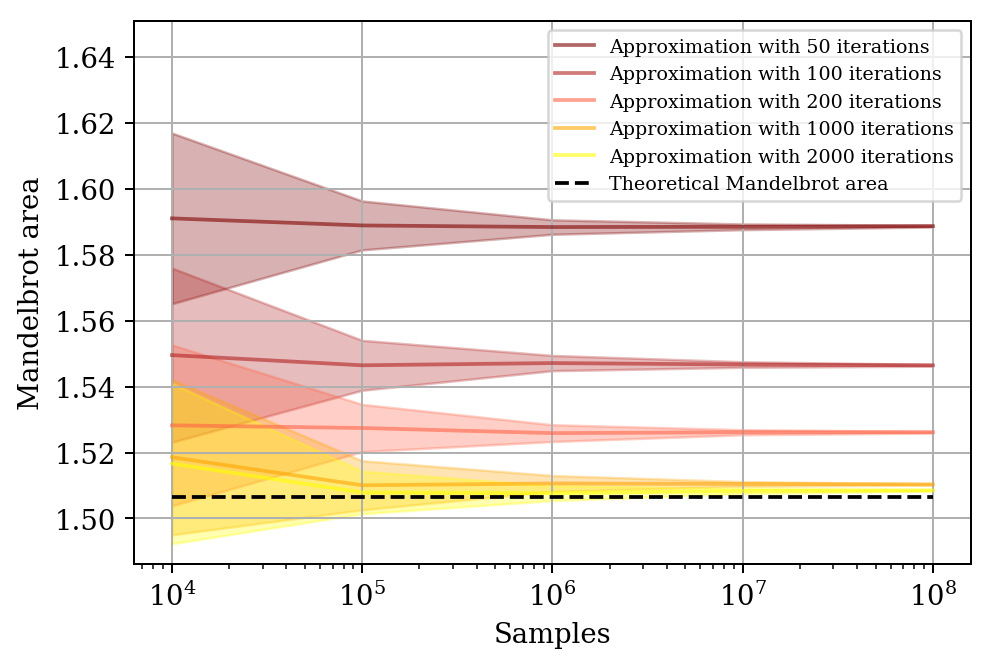

In [228]:
sample_variance_plotter(simulation_data = "monte_carlo_random_sampling", title = "line_plot_samples_random.png")

In [281]:
def iteration_variance_plotter(simulation_data, title):
    """"
    Plots mean area and standard deviation of the mandelbrot set 
    against sample sizes simulated with different number of 
    iterations
    """
    data = np.load(simulation_data + ".npz")
    
    mean_areas = data['arr_0']*2
    
    sample_variances = data['arr_1']*2
    
    mean_s_10_4 = [i[0] for i in mean_areas]
    mean_s_10_5 = [i[1] for i in mean_areas]
    mean_s_10_6 = [i[2] for i in mean_areas]
    mean_s_10_7 = [i[3] for i in mean_areas]
    mean_s_10_8 = [i[4] for i in mean_areas]

    std_s_10_4 = np.sqrt([i[0] for i in sample_variances])
    std_s_10_5 = np.sqrt([i[1] for i in sample_variances])
    std_s_10_6 = np.sqrt([i[2] for i in sample_variances])
    std_s_10_7 = np.sqrt([i[3] for i in sample_variances])
    std_s_10_8 = np.sqrt([i[4] for i in sample_variances])


    plt.plot(i_values, mean_s_10_4, alpha = 0.5, label = "Approximation with $10^4$ samples")
    plt.fill_between(i_values, mean_s_10_4 - std_s_10_4, mean_s_10_4 + std_s_10_4, alpha = 0.2)

    plt.plot(i_values, mean_s_10_5, alpha = 0.5, label = "Approximation with $10^5$ samples")
    plt.fill_between(i_values, mean_s_10_5 - std_s_10_5, mean_s_10_5 + std_s_10_5, alpha = 0.2)
    
    plt.plot(i_values, mean_s_10_6, alpha = 0.5, label = "Approximation with $10^6$ samples")
    plt.fill_between(i_values, mean_s_10_6 - std_s_10_6, mean_s_10_6 + std_s_10_6, alpha = 0.2)
    
    plt.plot(i_values, mean_s_10_7, alpha = 0.5, label = "Approximation with $10^7$ samples")
    plt.fill_between(i_values, mean_s_10_7 - std_s_10_7, mean_s_10_7 + std_s_10_7, alpha = 0.2)
    
    plt.plot(i_values, mean_s_10_8, alpha = 0.5, label = "Approximation with $10^8$ samples")
    plt.fill_between(i_values, mean_s_10_8 - std_s_10_8, mean_s_10_8 + std_s_10_8, alpha = 0.2)
    
    plt.hlines(1.50659, i_values[0], i_values[-1], label = "Theoretical Mandelbrot area", linestyles="dashed")

    plt.xlabel("Iterations")
    plt.ylabel("Mandelbrot area")
    plt.grid(True)
    plt.legend(loc="upper right", fontsize="x-small")
    
    plt.savefig(title)
    plt.show() 
    

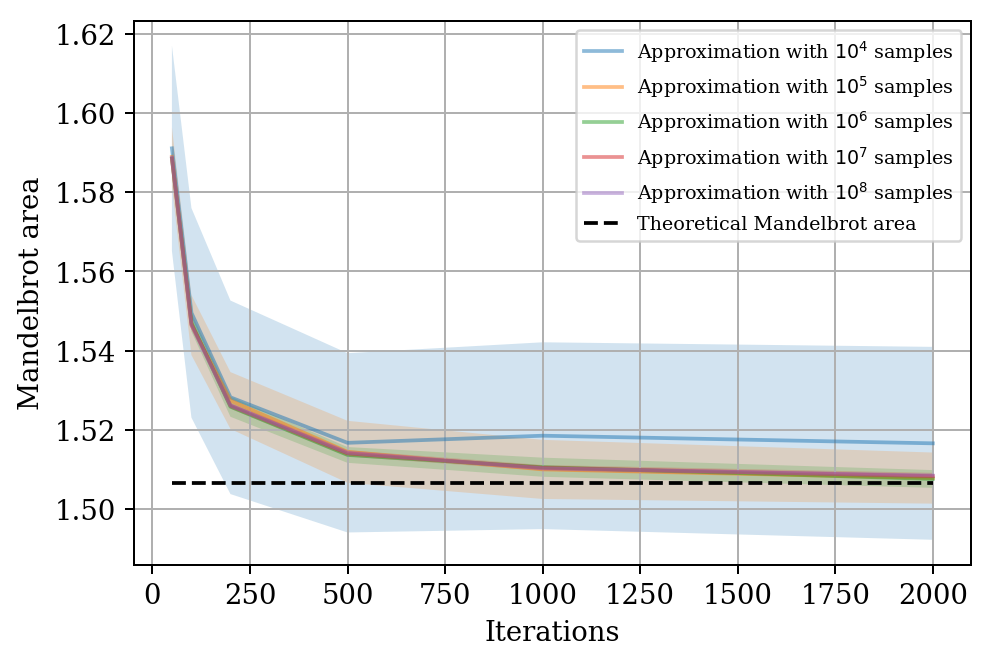

In [282]:
iteration_variance_plotter(simulation_data = "monte_carlo_random_sampling", title = "line_plot_iterations_random.png")

In [284]:
def sample_variance_box_plot(random_sampling_data, lhs_data, orthogonal_sampling_data, title):
    
    box_plot_list = [[], [], []]
    
    if data == np.load(random_sampling_data + ".npz"):
        mean_areas = data['arr_0']*2
        sample_variances = data['arr_1']*2 
        print(mean_i_100 = mean_areas[1])

    

In [9]:
# orthogonal sampling
nx = ny = n = 3
nsq = n*n
xlist = np.arange(nsq).reshape((n,n))
ylist = np.arange(nsq).reshape((n,n))
x_scale = 3.0/nsq
y_scale = 2.0/nsq
x_randos = []
y_randos = []
for i in range(n):
    xlist[i] = np.random.permutation(xlist[i])
    ylist[i] = np.random.permutation(ylist[i])
for i in range(n):
    for j in range(n):
        x = -2.0 * x_scale + xlist[i][j] + np.int32(np.random.uniform())
        y = -1.0 * y_scale + ylist[j][i] + np.int32(np.random.uniform())
        x_randos.append(x)
        y_randos.append(y)
            

In [10]:
len(x_randos)

9

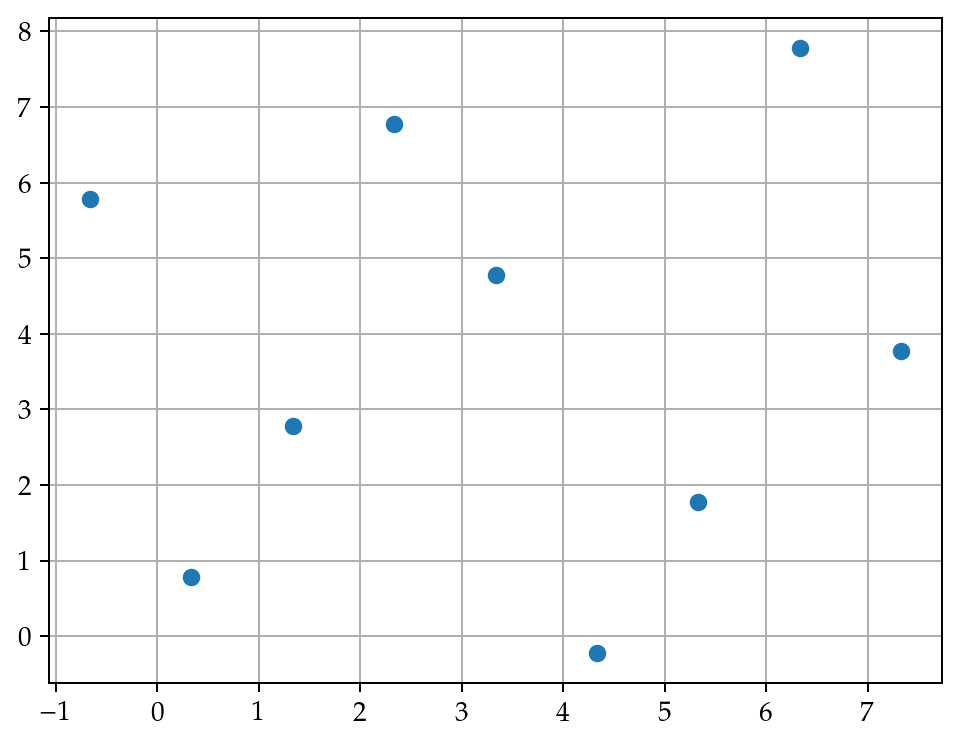

In [12]:
plt.scatter(x_randos, y_randos)
plt.grid(b = True)
plt.show()